1. Query GFS data, full extent and small part vitual file
2. Plot the virtual data
3. Create actual netCDF files
4. Store the files as netCDF

In [1]:
# for autocompletion disable the autocompletion tool 'jedi'
%config Completer.use_jedi = False


# formatter
%load_ext nb_black

<IPython.core.display.Javascript object>

The coordinate system of the GFS Data is a little unusual, as longitudes run from 0 to 360 degrees. So a full extend would be latitudes -90° (south) to 90° (north) and longitudes 0° (west) to 360° (east).
Furthermore, there is a restriction in the way you can query data. Your west longitude coordinate needs to be smaller than the east coordinate. Accordingly, you cannot set a bounding box for a small area including the Meridian as then your west coordinate would be greater than the east coordinate.
Instead you may need to consider to query the full extend for the longitude.
We will have a look at this circumstance in this Jupyter Notebook.  

In this notebook we will use the NetCDF Subset Service (NCSS). For specifications have a look its rerefence: https://www.unidata.ucar.edu/software/tds/current/reference/NetcdfSubsetServiceReference.html


# Query GFS Data

In [2]:
from siphon.catalog import TDSCatalog

"""
    Siphon is a collection of Python utilities for downloading data from remote data services. 
    Much of Siphon’s current functionality focuses on access to data hosted on a THREDDS Data Server. 
    It also provides clients to a variety of simple web services.
    Link to documentation:https://unidata.github.io/siphon/latest/index.html
"""

'\n    Siphon is a collection of Python utilities for downloading data from remote data services. \n    Much of Siphon’s current functionality focuses on access to data hosted on a THREDDS Data Server. \n    It also provides clients to a variety of simple web services.\n    Link to documentation:https://unidata.github.io/siphon/latest/index.html\n'

<IPython.core.display.Javascript object>

### Read a catalog from TDS

In [3]:
"""
    Read a catalog from THREDDS Data Server (TDS). THREDDS Catalogs are 
    logical directories of on-line data resources, encoded as XML documents, 
    which provide a place for annotations and other metadata about the data resources 
    to reside. This is how THREDDS-enabled data consumers find out what data is available 
    from data providers. 
    
    First construct a TDSCatalog instance pointing to the dataset of interest, in this 
    case TDS’ “Best” virtual dataset for the GFS global 0.25 degree collection of 
    GRIB files. 
    This catalog contains a single dataset.
"""
# Catalog https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.html
best_gfs = TDSCatalog(
    catalog_url="http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/"
    "Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best"
)

# Give out the name of the dataset
best_gfs.datasets

['Best GFS Quarter Degree Forecast Time Series']

<IPython.core.display.Javascript object>

In [4]:
# Inspect the metdata of the dataset
best_gfs.metadata

{'inherited': True,
 'serviceName': 'VirtualServices',
 'authority': ['edu.ucar.unidata'],
 'dataType': 'GRID',
 'dataFormat': 'GRIB-2',
 'documentation': {'summary': ['Forecasts grids starting from the 0 hour forecast every 3 hours out to 10 days, then 12 hour forecasts for days 10-16.',
   'NCEP GFS Model : AWIPS 230 (G) Grid. Global Lat/Lon grid. Model runs at 0, 6, 12, and 18Z. Horizontal= 721 by 14400 points, resolution 0.25 degree, Lat/Lon projection. Vertical= 1000 to 100 hPa mandatory pressure levels (26 levels); surface, height above ground, pressure layers.',
   'NCEP Global Forecast System Model, previously called AVN/MRF (Medium Range Forecast)'],
  'xlink': [{'title': 'COMET MetEd (Meteorology Education and Training) documentation',
    'href': 'http://meted.ucar.edu/nwp/pcu2/avintro.htm'},
   {'title': 'NCEP Model Notes',
    'href': 'http://www.nco.ncep.noaa.gov/pmb/products/gfs/'},
   {'title': 'NCEP Model documentation',
    'href': 'http://www.emc.ncep.noaa.gov/modeli

<IPython.core.display.Javascript object>

In [5]:
# Pull out the dataset
best_ds = list(best_gfs.datasets.values())[0]
best_ds

Best GFS Quarter Degree Forecast Time Series

<IPython.core.display.Javascript object>

In [6]:
# Call subset() to prepare a request of a subset of the data
# by calling subset() you open the remote dataset and get a client for talking to service
ncss1 = best_ds.subset()  # ncss = netcdf subset service

# Look at the subset object variables to see what data are available from the dataset
# ncss1.variables

<IPython.core.display.Javascript object>

In [7]:
# How many variables are in the dataset?
len(list(ncss1.variables))

157

<IPython.core.display.Javascript object>

# Define query
Before requesting a variable we construct a query by taking the following steps:
- create an empty query object
- define an area, e.g. by setting a bounding box
- specify the time dimension, e.g. a time range or a certain time stamp, or the actual time
- select the relevant variable(s)

In [8]:
from datetime import datetime

<IPython.core.display.Javascript object>

In [9]:
# Use the ncss object to create a new query object, which facilitates asking for data from the server.
query1 = ncss1.query()

<IPython.core.display.Javascript object>

### Define area

The coordinate system the GFS is a bit unusual as its Longitudes run from 0 to 360.

In [10]:
# Full extent
fe_West = 0
fe_East = 360
fe_South = -90
fe_North = 90

query1.lonlat_box(west=fe_West, east=fe_East, south=fe_South, north=fe_North)

west=0&east=360&south=-90&north=90

<IPython.core.display.Javascript object>

In [11]:
# Bounding Box for a small area
# sa_West = 14.8
# sa_East = 156.4
# sa_South = -55.6
# sa_North = 47

# query.lonlat_box(west=sa_West, east=sa_East, south=sa_South, north=sa_North)

<IPython.core.display.Javascript object>

In [12]:
# Single data point

# sg_West = 20.49
# sg_East = 20.49 + 0.125
# sg_South = -49.24 - 0.125
# sg_North = -49.24

# query.lonlat_box(west=sg_West, east=sg_East, south=sg_South, north=sg_North)

<IPython.core.display.Javascript object>

In [13]:
# Query a certain area and take the datetime closest to the actual datetime

# https://unidata.github.io/siphon/latest/api/http_util.html#siphon.http_util.DataQuery.lonlat_box
# query.lonlat_box(south=fe_South,
#                  north=fe_North,
#                  west=fe_West,
#                  east=fe_East).time(
#     datetime.utcnow()
# )


<IPython.core.display.Javascript object>

### Define the time or time range for the query
If you don't set a bounding box, the full extent will be queried.
According to the official website of the GFS, the GFS produces forecast output every hour for the first 120 hours, then every 3 hours for days 5-16. (https://www.emc.ncep.noaa.gov/emc/pages/numerical_forecast_systems/gfs.php)
However, this does not match with the effectively delivered data when querying. Instead, we get back 3 hourly forecast until day 10, then 12 hourly forecast till day 16.

In [14]:
# Set the requested time to the time closest to actual time.
# rla = query.time(datetime.utcnow())

<IPython.core.display.Javascript object>

In [15]:
# Query a certain time range
# https://unidata.github.io/siphon/latest/api/http_util.html#siphon.http_util.DataQuery.time_range
# query.time_range(start=datetime(2021, 3, 9, 0), end=datetime(2021, 3, 25, 23))

<IPython.core.display.Javascript object>

In [16]:
# Query a certain date.
# https://unidata.github.io/siphon/latest/api/http_util.html#siphon.http_util.DataQuery.time
query1.time(datetime(2021, 3, 9, 21))

time=2021-03-09T21%3A00%3A00&west=0&east=360&south=-90&north=90

<IPython.core.display.Javascript object>

In [17]:
# Set data format to be accepted, here netcdf4
query1.accept("netcdf4")  # csv

time=2021-03-09T21%3A00%3A00&west=0&east=360&south=-90&north=90&accept=netcdf4

<IPython.core.display.Javascript object>

In [18]:
# Set target variable
query1.variables(
    "Wind_speed_gust_surface",
    #    "Geopotential_height_maximum_wind",
    #    "Temperature_maximum_wind",
)

var=Wind_speed_gust_surface&time=2021-03-09T21%3A00%3A00&west=0&east=360&south=-90&north=90&accept=netcdf4

<IPython.core.display.Javascript object>

### Query the data

In [19]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

<IPython.core.display.Javascript object>

In [20]:
# Send request and open the received virtual data as xarray dataset
data1 = ncss1.get_data(query1)
data1 = xr.open_dataset(NetCDF4DataStore(data1))
data1

<xarray.Dataset>
Dimensions:                  (lat: 721, lon: 1440, time: 1)
Coordinates:
    reftime                  (time) datetime64[ns] ...
  * time                     (time) datetime64[ns] 2021-03-09T21:00:00
  * lat                      (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                      (lon) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
Data variables:
    Wind_speed_gust_surface  (time, lat, lon) float32 ...
    LatLon_Projection        int32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

<IPython.core.display.Javascript object>

#### Download the data
As the requested dataset is just a virtual dataset you can also downlaod and store it on your local system

In [21]:
# Download the data as netCDF
# lala = data1.to_netcdf("52N_days_Wind1.nc")

<IPython.core.display.Javascript object>

In [22]:
# We want to inpect the variable Wind_speed_gust_surface
wind_3d = data1.Wind_speed_gust_surface
wind_3d

<xarray.DataArray 'Wind_speed_gust_surface' (time: 1, lat: 721, lon: 1440)>
[1038240 values with dtype=float32]
Coordinates:
    reftime  (time) datetime64[ns] 2021-03-09T06:00:00
  * time     (time) datetime64[ns] 2021-03-09T21:00:00
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:                      Wind speed (gust) @ Ground or water surface
    units:                          m/s
    abbreviation:                   GUST
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-2-22_L1
    Grib2_Parameter:                [ 0  2 22]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Momentum
    Grib2_Parameter_Name:           Wind speed (gust)
    Grib2_Level_Type:               1
    Grib2_Level_Desc:               Ground or water surface
    Grib2_Generating_Process_Type:  Forecast

<IPython.core.display.Javascript object>

In [23]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename="time"):
    for coord_name in var.coords:
        if coord_name.startswith(time_basename):
            return var.coords[coord_name]
    raise ValueError("No time variable found for " + var.name)


lat_1d = data1["lat"]
lon_1d = data1["lon"]

<IPython.core.display.Javascript object>

In [24]:
# Get forecasted date and time

# split in date and time
time_1d = find_time_var(wind_3d)
forecast_datetime_raw = time_1d[0].values
forecast_datetime_split = str(forecast_datetime_raw).split("T")

# date
forecast_date = forecast_datetime_split[0]

# time
forecast_time = forecast_datetime_split[1].split(":")[0]
forecast_time

'21'

<IPython.core.display.Javascript object>

In [25]:
import numpy as np
from netCDF4 import num2date
from metpy.units import units

<IPython.core.display.Javascript object>

In [26]:
# Reduce the dimensions of the data and get as an array with units
wind_2d = wind_3d.metpy.unit_array.squeeze()

# Combine latitude and longitudes
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

<IPython.core.display.Javascript object>

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables

<IPython.core.display.Javascript object>

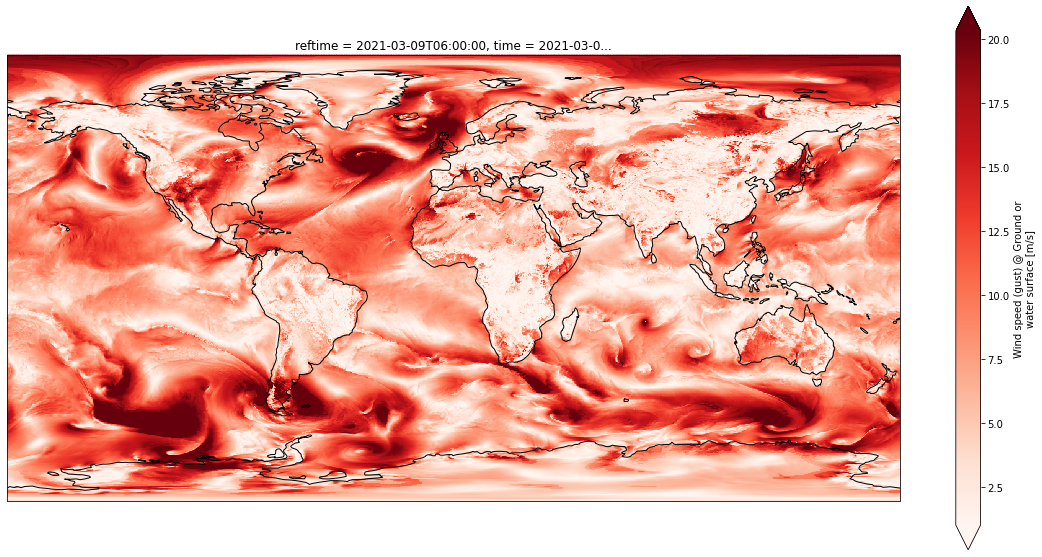

<IPython.core.display.Javascript object>

In [28]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
p = wind_3d.isel(time=0).plot(transform=ccrs.PlateCarree(), robust=True, cmap="Reds")

# Query data around meridian
The coordinate system of the GFS Data is a little unusual, as longitudes run from 0 to 360 degrees. So a full extend would be latitudes -90° (south) to 90° (north) and longitudes 0° (west) to 360° (east).
Furthermore, there is a restriction in the way you can query data. Your west longitude coordinate needs to be smaller than the east coordinate. Accordingly, you cannot set a bounding box for a small area including the Meridian as then your west coordinate would be greater than the east coordinate.
Instead you may need to consider to query the full extend for the longitude.
We will have a look at this circumstance in the following 

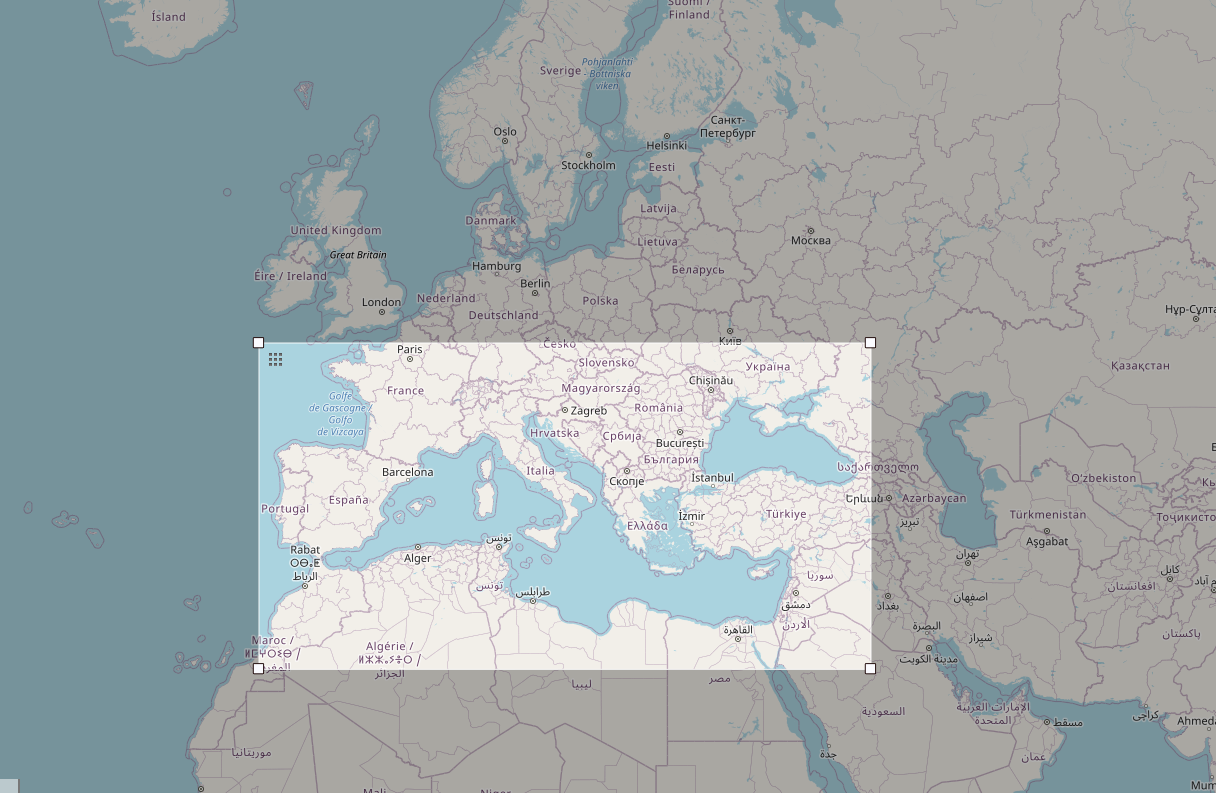

<IPython.core.display.Javascript object>

In [29]:
from IPython.display import Image

PATH = "/home/imke/Desktop/MariData/Data/GFS/images/"
image = Image(filename=PATH + "MediterraneanSea.png", width=800, height=800)
image

The above bounding box corresponds to the bounding box as defined below. However, this bounding box is not working as the west coordinates are larger than the east coordinates

In [30]:
# Bounding Box for a small area
# This bounding box does NOT work with the netcdf subset service as usual.
sa_West = -10.90 + 360
sa_East = 42.89
sa_South = 27.76
sa_North = 49.78

<IPython.core.display.Javascript object>

In [31]:
# from siphon.catalog import TDSCatalog

# """
#     Read a catalog from THREDDS Data Server
#     First we construct a TDSCatalog instance pointing to our dataset of interest, in this case TDS’ “Best” virtual
#     dataset for the GFS global 0.25 degree collection of GRIB files. This will give us a good resolution
#     for our map. This catalog contains a single dataset.
# """
# best_gfs = TDSCatalog(
#     "http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/"
#     "Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best"
# )
# best_gfs.datasets

<IPython.core.display.Javascript object>

In [32]:
# We pull out this dataset and call subset() to set up requesting a subset of the data.
best_ds = list(best_gfs.datasets.values())[0]
ncss2 = best_ds.subset()

<IPython.core.display.Javascript object>

In [33]:
query2 = ncss2.query()

<IPython.core.display.Javascript object>

In [34]:
# now we want to query a subset with a certain bounding box and variable
from datetime import datetime

query2.lonlat_box(north=sa_North, south=sa_South, east=sa_East, west=sa_West).time(
    datetime.utcnow()
)
query2.accept("netcdf4")
query2.variables("Wind_speed_gust_surface")

var=Wind_speed_gust_surface&time=2021-03-09T13%3A24%3A26.547186&west=349.1&east=42.89&south=27.76&north=49.78&accept=netcdf4

<IPython.core.display.Javascript object>

In [36]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

data2 = ncss2.get_data(query2)
data2 = xr.open_dataset(NetCDF4DataStore(data2))
data2

HTTPError: Error accessing https://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p25deg/Best?var=Wind_speed_gust_surface&time=2021-03-09T13%3A24%3A26.547186&west=349.1&east=42.89&south=27.76&north=49.78&accept=netcdf4
Server Error (400: Invalid bbox. Bounding Box must have east > west; if crossing 180 meridian, use east boundary > 180)

<IPython.core.display.Javascript object>

In [37]:
# Bounding Box for a small area west of the meridian
w_West = -10.90 + 360
w_East = 360
w_South = 27.76
w_North = 49.78

ncssW = best_ds.subset()

queryW = ncssW.query()

queryW.lonlat_box(north=w_North, south=w_South, east=w_East, west=w_West).time(
    datetime.utcnow()
)

queryW.accept("netcdf4")
queryW.variables("Wind_speed_gust_surface")

dataW = ncssW.get_data(queryW)
dataW = xr.open_dataset(NetCDF4DataStore(dataW))
dataW

<xarray.Dataset>
Dimensions:                  (lat: 89, lon: 44, time: 1)
Coordinates:
    reftime                  (time) datetime64[ns] ...
  * time                     (time) datetime64[ns] 2021-03-09T12:00:00
  * lat                      (lat) float32 49.75 49.5 49.25 ... 28.25 28.0 27.75
  * lon                      (lon) float32 349.0 349.2 349.5 ... 359.5 359.8
Data variables:
    Wind_speed_gust_surface  (time, lat, lon) float32 ...
    LatLon_Projection        int32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

<IPython.core.display.Javascript object>

In [39]:
wind3DW = dataW.Wind_speed_gust_surface

<IPython.core.display.Javascript object>

In [ ]:
# import pandas as pd

# # Helper function for finding proper time variable
# def find_time_var(var, time_basename="time"):
#     for coord_name in var.coords:
#         if coord_name.startswith(time_basename):
#             return var.coords[coord_name]
#     raise ValueError("No time variable found for " + var.name)


# lat_1d = data["lat"]
# lon_1d = data["lon"]

In [ ]:
# Get forecasted date and time

# split in date and time
# time1D = find_time_var(wind3D)
# forecast_datetime_raw = time1D[0].values
# forecast_datetime_split = str(forecast_datetime_raw).split("T")

# # date
# forecast_date = forecast_datetime_split[0]

# # time
# forecast_time = forecast_datetime_split[1].split(":")[0]
# time1D[0]

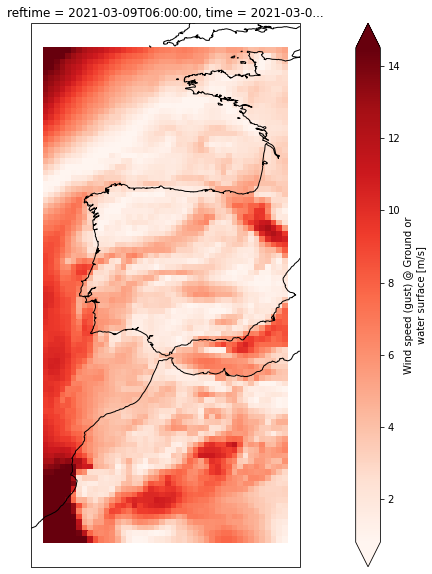

<IPython.core.display.Javascript object>

In [40]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
p = wind3DW.isel(time=0).plot(transform=ccrs.PlateCarree(), robust=True, cmap="Reds")

In [42]:
# Bounding Box for a small area east of the meridian
e_West = 0
e_East = 42.89
e_South = 27.76
e_North = 49.78

ncssE = best_ds.subset()

queryE = ncssE.query()

queryE.lonlat_box(north=e_North, south=e_South, east=e_East, west=e_West).time(
    datetime.utcnow()
)

queryE.accept("netcdf4")
queryE.variables("Wind_speed_gust_surface")

dataE = ncssE.get_data(queryE)
dataE = xr.open_dataset(NetCDF4DataStore(dataE))
dataE

<xarray.Dataset>
Dimensions:                  (lat: 89, lon: 173, time: 1)
Coordinates:
    reftime                  (time) datetime64[ns] ...
  * time                     (time) datetime64[ns] 2021-03-09T12:00:00
  * lat                      (lat) float32 49.75 49.5 49.25 ... 28.25 28.0 27.75
  * lon                      (lon) float32 0.0 0.25 0.5 0.75 ... 42.5 42.75 43.0
Data variables:
    Wind_speed_gust_surface  (time, lat, lon) float32 ...
    LatLon_Projection        int32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

<IPython.core.display.Javascript object>

In [44]:
wind3DE = dataE.Wind_speed_gust_surface
wind3DE

<xarray.DataArray 'Wind_speed_gust_surface' (time: 1, lat: 89, lon: 173)>
array([[[5.519909, 5.319909, ..., 2.019909, 3.119909],
        [5.019909, 4.619909, ..., 4.419909, 2.819909],
        ...,
        [1.019909, 1.119909, ..., 1.919909, 1.819909],
        [1.019909, 1.119909, ..., 1.719909, 1.719909]]], dtype=float32)
Coordinates:
    reftime  (time) datetime64[ns] 2021-03-09T06:00:00
  * time     (time) datetime64[ns] 2021-03-09T12:00:00
  * lat      (lat) float32 49.75 49.5 49.25 49.0 48.75 ... 28.5 28.25 28.0 27.75
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 42.0 42.25 42.5 42.75 43.0
Attributes:
    long_name:                      Wind speed (gust) @ Ground or water surface
    units:                          m/s
    abbreviation:                   GUST
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-2-22_L1
    Grib2_Parameter:                [ 0  2 22]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Momentum
    Grib2_Parameter_Name:           Wind speed (gust)
    Grib2_Level_Type:               1
    Grib2_Level_Desc:               Ground or water surface
    Grib2_Generating_Process_Type:  Forecast

<IPython.core.display.Javascript object>

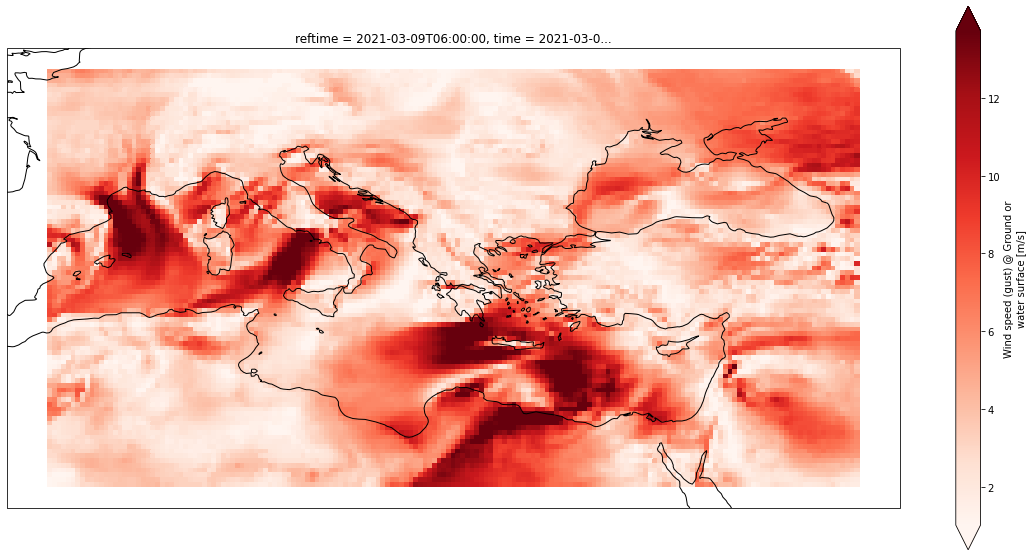

<IPython.core.display.Javascript object>

In [45]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
p = wind3DE.isel(time=0).plot(transform=ccrs.PlateCarree(), robust=True, cmap="Reds")

In [46]:
dataB = dataE.merge(dataW)

<IPython.core.display.Javascript object>

In [47]:
dataB

<xarray.Dataset>
Dimensions:                  (lat: 89, lon: 217, time: 1)
Coordinates:
  * lon                      (lon) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
    reftime                  (time) datetime64[ns] 2021-03-09T06:00:00
  * time                     (time) datetime64[ns] 2021-03-09T12:00:00
  * lat                      (lat) float32 49.75 49.5 49.25 ... 28.25 28.0 27.75
Data variables:
    Wind_speed_gust_surface  (time, lat, lon) float32 5.52 5.32 ... 1.62 1.12
    LatLon_Projection        int32 0
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

<IPython.core.display.Javascript object>

In [48]:
windB = dataB.Wind_speed_gust_surface

<IPython.core.display.Javascript object>

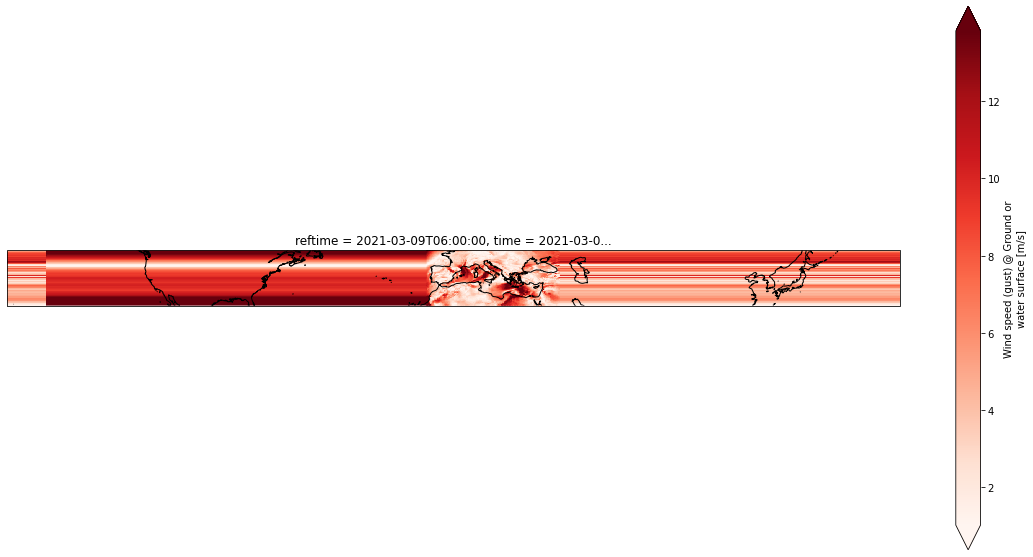

<IPython.core.display.Javascript object>

In [49]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
p = windB.isel(time=0).plot(transform=ccrs.PlateCarree(), robust=True, cmap="Reds")